In [1]:
import boto3
import sagemaker
import io
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
bucket_name = 's3team92'
key = 'iot_aggregated.json'

s3_client = boto3.client('s3')

obj = s3_client.get_object(Bucket=bucket_name, Key=key)
data = obj['Body'].read()

df = pd.read_json(io.BytesIO(data))

In [3]:
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [4]:
df.head(2)

,DateTime,AirCode,AirplaneModel,Passengers,FromAirport,ToAirport,Aluminum Cans,Cups,Cutleries,Food Waste (kg),Liquid (L),Non-recyclable Waste (kg),One-time Food Containers
0,2024-11-01 08:00:00,UO901,Airbus A320,180,HKG,TYO,80.0,299.99,150.00,45.0,34.99,60.0,149.98
1,2024-11-01 09:30:00,UO902,Airbus A320,159,TYO,TPE,90.0,360.02,179.99,52.0,40.00,70.0,180.00


18:13:05 - cmdstanpy - INFO - Chain [1] start processing
18:13:05 - cmdstanpy - INFO - Chain [1] done processing


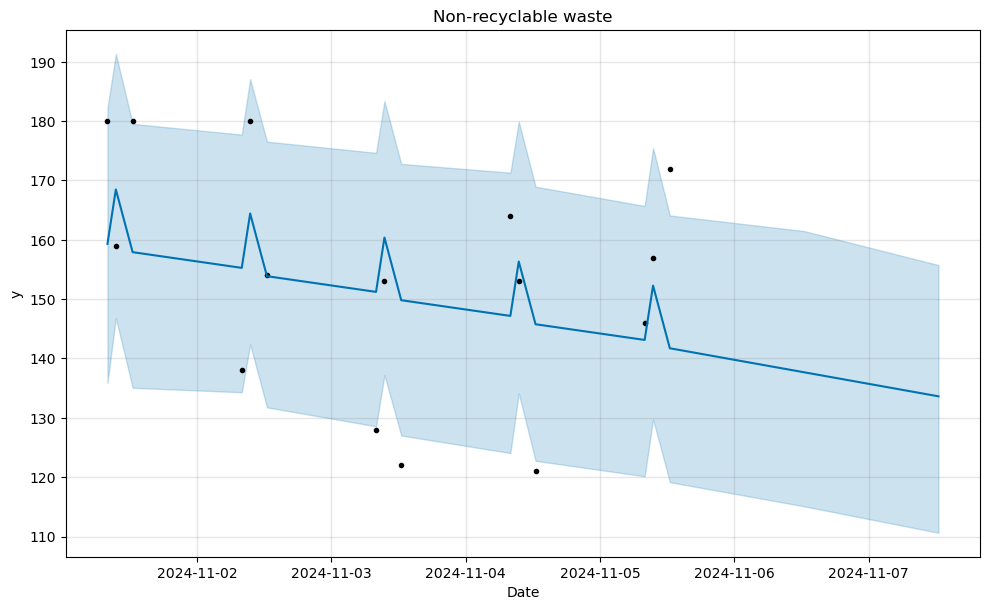

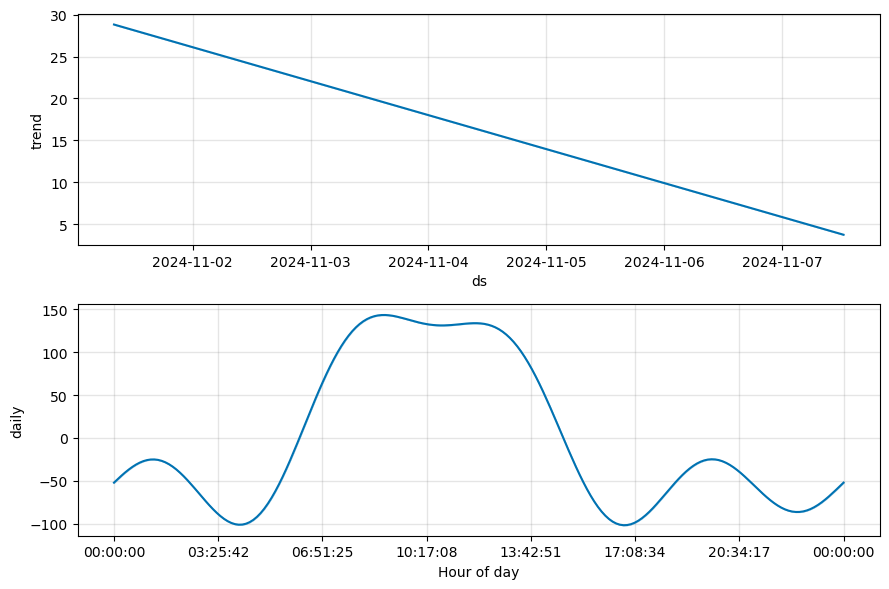

In [5]:
tmp = df.copy()

tmp = tmp.rename(columns={'DateTime': 'ds', 'Passengers': 'y'})

model = Prophet()
model.fit(tmp)

future = model.make_future_dataframe(periods=2, freq='D')

forecast = model.predict(future)

model.plot(forecast)
plt.title('Non-recyclable waste')
plt.xlabel('Date')
plt.show()

model.plot_components(forecast)
plt.show()

18:13:06 - cmdstanpy - INFO - Chain [1] start processing
18:13:06 - cmdstanpy - INFO - Chain [1] done processing


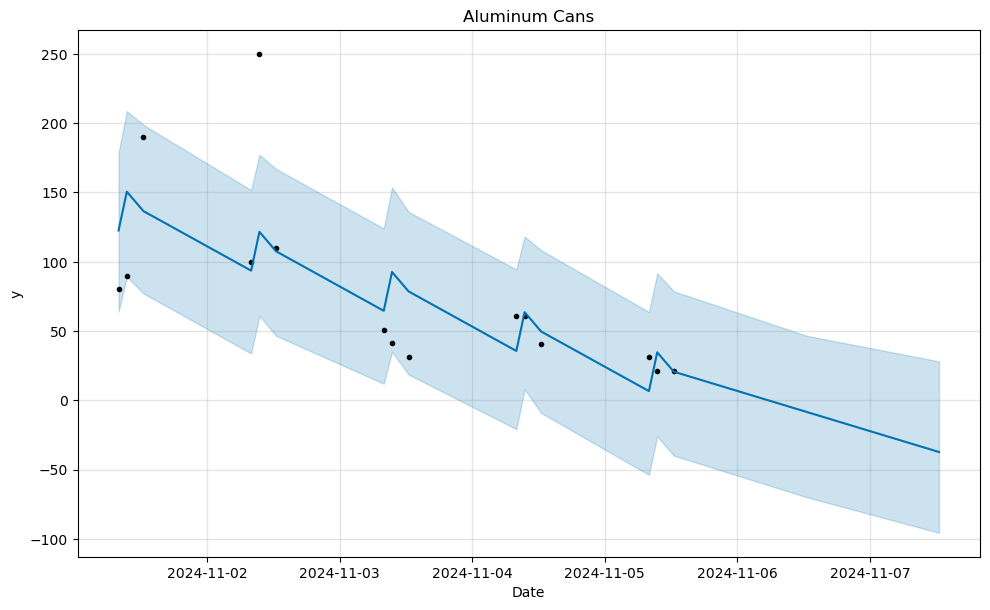

In [6]:
tmp = df.copy()

tmp = tmp.rename(columns={'DateTime': 'ds', 'Aluminum Cans': 'y'})

model = Prophet()
model.fit(tmp)

future = model.make_future_dataframe(periods=2, freq='D')

forecast = model.predict(future)

model.plot(forecast)
plt.title('Aluminum Cans')
plt.xlabel('Date')
plt.show()

18:13:06 - cmdstanpy - INFO - Chain [1] start processing
18:13:06 - cmdstanpy - INFO - Chain [1] done processing


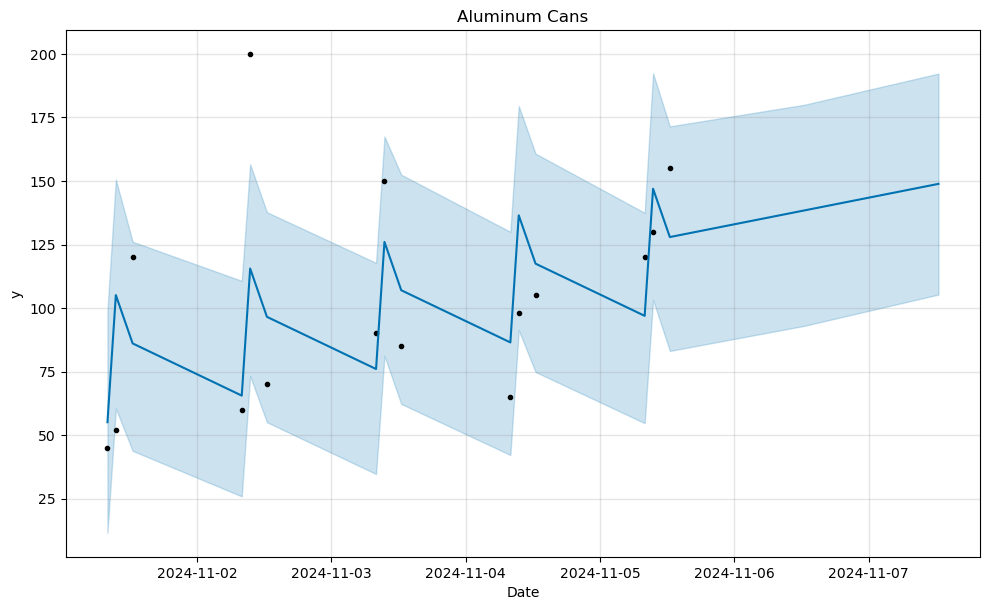

In [7]:
tmp = df.copy()

tmp = tmp.rename(columns={'DateTime': 'ds', 'Food Waste (kg)': 'y'})

model = Prophet()
model.fit(tmp)

future = model.make_future_dataframe(periods=2, freq='D')

forecast = model.predict(future)

model.plot(forecast)
plt.title('Aluminum Cans')
plt.xlabel('Date')
plt.show()

In [8]:
df.columns

Index(['DateTime', 'AirCode', 'AirplaneModel', 'Passengers', 'FromAirport',
       'ToAirport', 'Aluminum Cans', 'Cups', 'Cutleries', 'Food Waste (kg)',
       'Liquid (L)', 'Non-recyclable Waste (kg)', 'One-time Food Containers'],
      dtype='object')

In [9]:
def calculate_esg_score(row):
    positive_score = (row['Aluminum Cans'] + row['Cups'] + row['Cutleries'] + row['Food Waste (kg)'] + row['One-time Food Containers'] + row['One-time Food Containers'] / row['Passengers'])
    negative_score = (row['Non-recyclable Waste (kg)']) / row['Passengers']
    esg_score = positive_score - negative_score
    return esg_score

df['ESG Score'] = df.apply(calculate_esg_score, axis=1)

scaler = MinMaxScaler(feature_range=(2, 5))
df['ESG Score'] = scaler.fit_transform(df[['ESG Score']])

In [10]:
df

,DateTime,AirCode,AirplaneModel,Passengers,FromAirport,ToAirport,Aluminum Cans,Cups,Cutleries,Food Waste (kg),Liquid (L),Non-recyclable Waste (kg),One-time Food Containers,ESG Score
0,2024-11-01 08:00:00,UO901,Airbus A320,180,HKG,TYO,80.00,299.99,150.00,45.00,34.99,60.00,149.98,2.000000
1,2024-11-01 09:30:00,UO902,Airbus A320,159,TYO,TPE,90.00,360.02,179.99,52.00,40.00,70.00,180.00,2.315775
2,2024-11-01 12:30:00,UO903,Airbus A320,180,TPE,HKG,190.00,700.00,350.00,119.99,90.00,149.99,350.00,4.267970
3,2024-11-02 08:00:00,UO901,Airbus A320,138,DFW,DEN,100.00,400.01,200.01,60.00,49.99,80.00,150.00,2.425823
4,2024-11-02 09:30:00,UO902,Airbus A320,180,DXB,LHR,250.00,1000.01,499.99,200.01,150.00,219.98,80.00,5.000000
5,2024-11-02 12:30:00,UO903,Airbus A320,154,CDG,JFK,110.00,440.00,219.99,70.00,55.01,89.99,120.00,2.540087
6,2024-11-03 08:00:00,UO901,Airbus A320,128,FRA,HND,51.00,600.00,300.01,90.00,75.01,70.00,100.00,2.956711
7,2024-11-03 09:30:00,UO902,Airbus A320,153,DXB,SYD,41.01,800.01,400.01,150.02,110.00,80.02,90.01,3.738788
8,2024-11-03 12:30:00,UO903,Airbus A320,122,JFK,LHR,31.02,560.00,280.00,85.00,69.99,60.00,70.01,2.691787
9,2024-11-04 08:00:00,UO903,Airbus A320,164,HKG,TYO,60.99,560.00,200.01,65.00,84.00,50.00,89.00,2.574724


In [11]:
s3_client = boto3.client('s3')

bucket_name = 's3team92'
key = 'iot_calculated.json'

buffer = io.BytesIO()

df.to_json(buffer, orient='records', lines=True)

s3_client.put_object(Bucket=bucket_name, Key=key, Body=buffer.getvalue())

{'ResponseMetadata': {'RequestId': '527X7CQ3AB6S91K6',
  'HostId': 'XEkZJcXZkarkrTrsm7vGzCbg5K7pKb+2hos48oFeVSaBYEXh5ED2WoGiLH3d4ocj9Vd8lSNaIIZoRLOJjVoWiRLt2JJHzJUWY9YWlt75yEA=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'XEkZJcXZkarkrTrsm7vGzCbg5K7pKb+2hos48oFeVSaBYEXh5ED2WoGiLH3d4ocj9Vd8lSNaIIZoRLOJjVoWiRLt2JJHzJUWY9YWlt75yEA=',
   'x-amz-request-id': '527X7CQ3AB6S91K6',
   'date': 'Wed, 06 Nov 2024 18:13:08 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"fcce69d95b1b4b9980639f6dd7fc0065"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"fcce69d95b1b4b9980639f6dd7fc0065"',
 'ServerSideEncryption': 'AES256'}